In [51]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from typing import NamedTuple, Tuple
import numpy.typing as npt
from tqdm import tqdm
import random

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

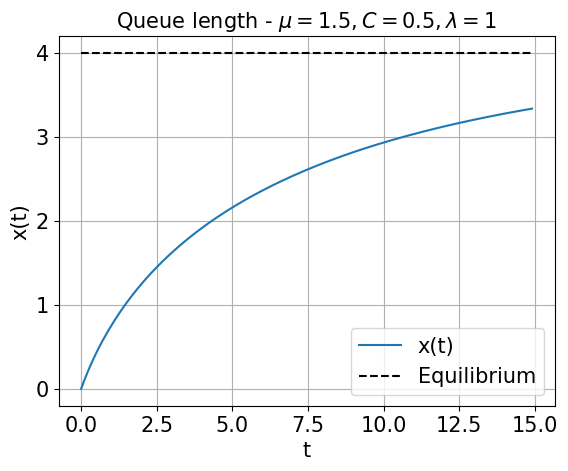

In [88]:
C = 1/2
MU = 1.5
LMBD = 1
NUM_POINTS = 150 
DELTA = 0.1 

class Parameters(NamedTuple):
    C: float
    MU: float
    LMBD: float
    
    @property
    def stationary_point(self) -> float: return LMBD / (C * (MU - LMBD))

def f(t, y, p: Parameters):
    """this is the rhs of the ODE to integrate, i.e. dy/dt=f(y,t)"""
    return -p.MU * p.C * y / (1 + p.C * y) + p.LMBD


def generate_data(x0: float, num_points: int, delta: float, parameters: Parameters) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    y0 = [x0]           # initial value y0=y(t0)
    t0 = 0             # integration limits for t: start at t0=0
    tf = 150 * delta   # and finish at tf=10
    t_eval = np.arange(t0, tf, delta)
    sol = solve_ivp(fun=lambda t,y: f(t, y, parameters), t_span=[t0, tf], y0=y0, t_eval=t_eval)  # computation of Solution 
    return sol.t, sol.y[0]

params = Parameters(C, MU, LMBD)
t, x = generate_data(0, NUM_POINTS, DELTA, params)

plt.plot(t, x, label='x(t)')
plt.plot(t, np.ones_like(t) * params.stationary_point, 'k--', label='Equilibrium')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Queue length - $\mu=' + str(MU) + f', C={C}, \\lambda={LMBD}$')
plt.show()

In [159]:

## PREPARE DATA
# def normalize(x, x_min, x_max):
#     return (x - x_min) / (x_max - x_min)


# x_min, x_max = 0, 5
# x_normalized = normalize(x, x_min, x_max)

# Shuffle data

dataset = np.vstack([x[:-1], x[1:]]).T
rand_idxs = torch.randperm(len(dataset))
x_shuffled = dataset[rand_idxs]

x_train = torch.tensor(x_shuffled[:50], dtype=torch.float32)
x_test = torch.tensor(x_shuffled[50:], dtype=torch.float32)


In [160]:
## Network definition

class Network(nn.Module):
    def __init__(self, hidden_size: int = 16):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(1, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


[Epoch 2999] Avg loss: 2.535895168875868e-05 - Validation loss: 0.00010765199112938717: 100%|██████████| 3000/3000 [00:16<00:00, 182.97it/s] 


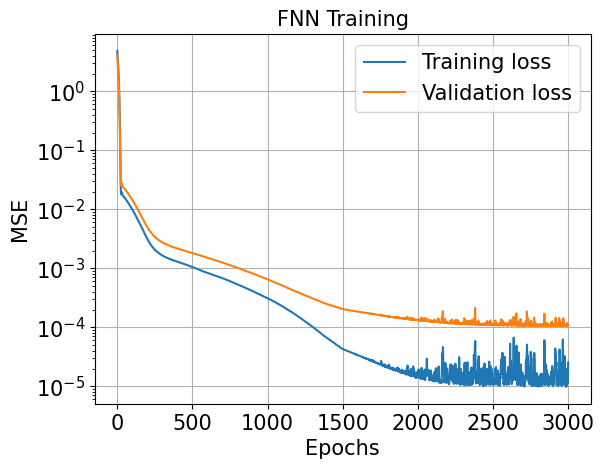

In [175]:
network = Network()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

EPOCHS = 3000
BATCH_SIZE = 16
trange = tqdm(range(EPOCHS))

rand_idxs = torch.randperm(x_train.size()[0])
data_batches = torch.utils.data.BatchSampler(x_train[rand_idxs], BATCH_SIZE, False)
random_batches = list(data_batches)

training_loss = []
validation_loss = []

for epoch in trange:
    random.shuffle(random_batches)
    losses = []
    for batch in random_batches:
        batch = torch.stack(batch, 0)
        out = network(batch[:, 0].unsqueeze(-1))
        loss = nn.MSELoss()(out, batch[:, 1].unsqueeze(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    # Compute validation loss
    with torch.no_grad():
        out_val = network(x_test[:,0].unsqueeze(-1))
        loss_val = nn.MSELoss()(out_val, x_test[:,1].unsqueeze(-1))
    trange.set_description(f'[Epoch {epoch}] Avg loss: {np.mean(losses)} - Validation loss: {loss_val}')
    
    
    training_loss.append(np.mean(losses))
    validation_loss.append(loss_val)

plt.plot(range(EPOCHS), training_loss, label='Training loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation loss')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('FNN Training')
plt.savefig('figures/fnn_training.png')

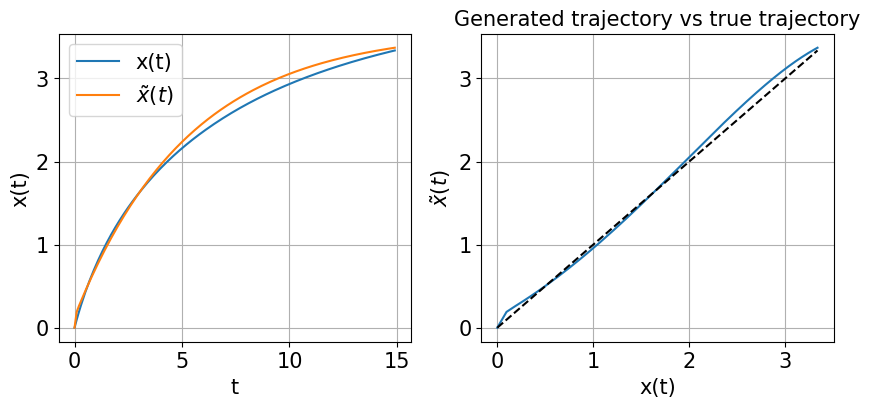

In [186]:
# Generate predicted trajectory and compare with true one

x_generated = [0]

x_t = torch.tensor([0], dtype=torch.float32)
for step in range(NUM_POINTS-1):
    x_tp1 = network(x_t)
    
    x_generated.append(x_tp1.item())
    x_t = x_tp1

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(t, x, label='x(t)')
ax[0].plot(t, x_generated, label=r'$\tilde{x}(t)$')
ax[0].set_xlabel('t')
ax[0].set_ylabel('x(t)')
ax[0].grid()
ax[0].legend()


ax[1].plot(x, x_generated)
ax[1].set_xlabel('x(t)')
ax[1].set_ylabel(r'$\tilde{x} (t)$')
ax[1].plot(x, x, 'k--')
ax[1].grid()
plt.title('Generated trajectory vs true trajectory')
plt.savefig('figures/fnn_phase.png')    